In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import sklearn
import random


In [95]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [96]:
filename = 'Dataset/Sensor_Discrimination_normalized.csv'
df=pd.read_csv(filename)
# shuffle the DataFrame rows
df = df.sample(frac = 1) #frac = fraction
dataset=df.iloc[:,:-1]
label=df.iloc[:,-1]
print(dataset)
print(label)

            F2        F3        F1       F11        F4        F6       F10  \
654   0.569198  0.866925  0.519099  0.186702  0.720605  0.134552  0.275602   
715   0.266310  0.885599  0.793144  0.188121  0.813238  0.400220  0.250188   
789   0.163465  0.920256  0.885602  0.192199  0.873108  0.567070  0.390060   
1961  0.119337  0.911339  0.778061  0.342021  0.917678  0.530511  0.689383   
766   0.223957  0.893506  0.746131  0.173794  0.822219  0.351017  0.216867   
...        ...       ...       ...       ...       ...       ...       ...   
1456  0.611337  0.608513  0.325759  0.193794  0.535007  0.043293  0.215926   
387   0.660321  0.501682  0.257199  0.170550  0.360552  0.014428  0.201054   
726   0.190866  0.870626  0.850539  0.198227  0.819225  0.539307  0.293298   
595   0.221176  0.901077  0.800784  0.197695  0.867454  0.460418  0.267508   
718   0.202888  0.908479  0.823310  0.192021  0.819558  0.474711  0.244917   

            F9        F5      F7      F12      F8  
654   0.209

In [97]:
pcaTrain = PCA(n_components=3).fit(dataset)# --train-- pca with the "dataset" Dataframe
print(pcaTrain)
compressed_dataset_X= pcaTrain.transform(dataset) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X))
print(len(compressed_dataset_X[0]))
print(compressed_dataset_X)

PCA(n_components=3)
<class 'numpy.ndarray'>
3
[[ 1.57117946 -0.50825339  0.07986403]
 [ 1.63062058 -0.22905738 -0.22910767]
 [ 1.39303591  0.05400007 -0.31136704]
 ...
 [ 0.97652718  0.02343892 -0.17835766]
 [16.10637881  0.5033303  -0.16584294]
 [ 0.80882501 -0.19868749 -0.30882391]]


In [98]:
dataset_arr=dataset.to_numpy()
# from NecessaryModules.splitData import split_data
X_train, X_test, y_train, y_test = train_test_split(dataset_arr, label, test_size=0.3, random_state=42)
print(len(X_train))

1548


In [99]:
compressed_dataset_X_train= pcaTrain.transform(X_train) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_train))
print(len(compressed_dataset_X_train))
print(compressed_dataset_X_train)

compressed_dataset_X_test= pcaTrain.transform(X_test) # --transform-- the original "dataset" Dataframe into a lower-dimensional space based on the model's learned parameters
print(type(compressed_dataset_X_test))
print(len(compressed_dataset_X_test))
print(compressed_dataset_X_test)

<class 'numpy.ndarray'>
1548
[[ 1.88049457 -0.73950016  0.10442432]
 [ 1.49760936 -0.3986497  -0.03417375]
 [-3.06928653 -0.281977   -0.36668908]
 ...
 [ 1.55494296 -0.21742346  0.0091188 ]
 [ 1.48653888  0.59087009 -0.1833134 ]
 [ 1.24315233 -0.65289401 -0.05096868]]
<class 'numpy.ndarray'>
664
[[-3.42371198  1.52126193  0.69052   ]
 [ 1.33974143 -0.6214661  -0.1069403 ]
 [ 1.30348846 -0.74378904  0.09968995]
 ...
 [-3.90513627 -1.30256663  0.35402689]
 [ 1.02514396 -0.85734914  0.30265169]
 [ 1.57772554 -0.30016595  0.19475083]]


# Tune D tree for Ada-boost

In [100]:
from sklearn.tree import DecisionTreeClassifier
params_dt = {'max_depth': 12,    
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)

model_dt.fit(compressed_dataset_X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features='sqrt')

In [101]:
# Finding mean absolute error
preds = model_dt.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.06626506024096386

In [102]:
# Defining the best parameter with optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
K = 5 # stratified 5 fold cross validation, The folds are made by preserving the percentage of samples for each class.
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_dt = np.array(compressed_dataset_X)
target_train_tunned_dt = np.array(label)

oof_preds_dt = np.zeros((len(train_tunned_dt)))
abs_error_arr_dt=[]
def objective(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned_dt[train_index], train_tunned_dt[val_index]
    train_Y, valid_Y = target_train_tunned_dt[train_index], target_train_tunned_dt[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
        'criterion':trial.suggest_categorical('criterion',["gini", "entropy", "log_loss"]), #The function to measure the quality of a split.
        'splitter':trial.suggest_categorical('splitter',["best", "random"]),
        'max_features':trial.suggest_categorical('max_features',['sqrt','log2',1,2,3,4,5,6,7,8,9,10,11]), #a categorical value can be an integer
        'random_state':trial.suggest_int('random_state',0,5),


        }
    model = DecisionTreeClassifier(**param)  
        
    model.fit(train_X,train_Y)
        
    preds = model.predict(valid_X)
    oof_preds_dt[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
#  print(len(oof_preds_dt))
      
 mae = mean_absolute_error(target_train_tunned_dt, oof_preds_dt)
        
 return mae

In [103]:
# this is the main optuna for optimizing a object-->"objective"
study = optuna.create_study(direction='minimize')

[I 2024-02-12 11:20:41,186] A new study created in memory with name: no-name-32f354f1-bd92-4724-9e6f-bc20ed277f26


In [104]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-12 11:20:41,236] Trial 0 finished with value: 0.06645569620253164 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 10, 'random_state': 5}. Best is trial 0 with value: 0.06645569620253164.
[I 2024-02-12 11:20:41,278] Trial 1 finished with value: 0.06329113924050633 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 7, 'random_state': 0}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,292] Trial 2 finished with value: 0.11301989150090416 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_features': 'log2', 'random_state': 5}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,305] Trial 3 finished with value: 0.07775768535262206 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_features': 4, 'random_state': 4}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,318] Trial 4 finished with value: 0.07640144665461121 and paramet

[I 2024-02-12 11:20:41,517] Trial 11 finished with value: 0.06329113924050633 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 7, 'random_state': 0}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,625] Trial 12 finished with value: 0.06329113924050633 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 7, 'random_state': 0}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,692] Trial 13 finished with value: 0.08770343580470162 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 'sqrt', 'random_state': 1}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,769] Trial 14 finished with value: 0.07685352622061482 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 2, 'random_state': 1}. Best is trial 1 with value: 0.06329113924050633.
[I 2024-02-12 11:20:41,826] Trial 15 finished with value: 0.0650994575045208 and parame

Number of finished trials: 100
Best trial: {'criterion': 'entropy', 'splitter': 'best', 'max_features': 7, 'random_state': 0}


In [105]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["criterion", "splitter","max_features","random_state"])
fig_study.show()

In [106]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.06329113924050633
  Params: 
    criterion: entropy
    splitter: best
    max_features: 7
    random_state: 0


# Tune Adaboost classifier

In [107]:
# train the model with random parameter
from sklearn.ensemble import AdaBoostClassifier
# Preparing the regressor and fitting data with some parameters
dt_params = study.best_trial.params
model_dt = DecisionTreeClassifier(**dt_params)
#model_dt = estimator
#model = predictor = model_dt.fit()

model_Ada = AdaBoostClassifier(
        estimator=model_dt,
        n_estimators=180, # maximum number of estimators at which boosting is terminated
        learning_rate=1.2,
        algorithm="SAMME", #SAMME.R=real boosting algorithm
        
     )

model_Ada.fit(compressed_dataset_X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_features=7,
                                                    random_state=0),
                   learning_rate=1.2, n_estimators=180)

In [108]:
# Finding mean absolute error
preds = model_Ada.predict(compressed_dataset_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.05421686746987952

In [109]:
# Defining the best parameter with optuna

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned_Ada= np.array(compressed_dataset_X)
target_train_tunned_Ada = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds_Ada = np.zeros((len(train_tunned_Ada)))
abs_error_arr_Ada=[]
def objective_Ada(trial):

 for train_index, val_index in (skf.split(compressed_dataset_X,label)):
    train_X, valid_X = train_tunned_Ada[train_index], train_tunned_Ada[val_index]
    train_Y, valid_Y = target_train_tunned_Ada[train_index], target_train_tunned_Ada[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
        'estimator':model_dt,
        'n_estimators':trial.suggest_int("n_estimators",50,500), # maximum number of estimators at which boosting is terminated
        'learning_rate':trial.suggest_float("learning_rate",1,3),
        'algorithm':trial.suggest_categorical("algorithm",["SAMME","SAMME.R"]),
        'random_state':trial.suggest_int('random_state',0,5),
        }
    model_2 = AdaBoostClassifier(**param)  
        
    model_2.fit(train_X,train_Y)
        
    preds = model_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds # preds gives total 3846 predicted value for valid_X

#  abs_error=np.abs(oof_preds-target_train_tunned).mean() 
#  abs_error_arr.append(abs_error)  
#  abs_error=np.abs(oof_preds-target_train).mean()
 
#  print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned_Ada, oof_preds_Ada)
        
 return mae

In [110]:
# this is the main optuna for optimizing a object-->"objective"
study_Ada = optuna.create_study(direction='minimize',study_name="Ada_tunning")

[I 2024-02-12 11:20:45,282] A new study created in memory with name: Ada_tunning


In [111]:

study_Ada.optimize(objective_Ada, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study_Ada.trials))
print('Best trial:', study_Ada.best_trial.params)

[I 2024-02-12 11:20:45,352] Trial 0 finished with value: 0.06871609403254973 and parameters: {'n_estimators': 236, 'learning_rate': 1.5803231862479403, 'algorithm': 'SAMME.R', 'random_state': 3}. Best is trial 0 with value: 0.06871609403254973.
[I 2024-02-12 11:20:45,409] Trial 1 finished with value: 0.06600361663652803 and parameters: {'n_estimators': 50, 'learning_rate': 1.132671754920058, 'algorithm': 'SAMME.R', 'random_state': 1}. Best is trial 1 with value: 0.06600361663652803.


[I 2024-02-12 11:20:45,463] Trial 2 finished with value: 0.06871609403254973 and parameters: {'n_estimators': 316, 'learning_rate': 2.2963660149425595, 'algorithm': 'SAMME', 'random_state': 3}. Best is trial 1 with value: 0.06600361663652803.
[I 2024-02-12 11:20:45,506] Trial 3 finished with value: 0.06645569620253164 and parameters: {'n_estimators': 183, 'learning_rate': 2.3455924827886223, 'algorithm': 'SAMME.R', 'random_state': 5}. Best is trial 1 with value: 0.06600361663652803.
[I 2024-02-12 11:20:45,547] Trial 4 finished with value: 0.06464737793851717 and parameters: {'n_estimators': 74, 'learning_rate': 2.493604876056324, 'algorithm': 'SAMME', 'random_state': 2}. Best is trial 4 with value: 0.06464737793851717.
[I 2024-02-12 11:20:45,598] Trial 5 finished with value: 0.06600361663652803 and parameters: {'n_estimators': 140, 'learning_rate': 1.1005531637719543, 'algorithm': 'SAMME.R', 'random_state': 1}. Best is trial 4 with value: 0.06464737793851717.
[I 2024-02-12 11:20:45,638

Number of finished trials: 100
Best trial: {'n_estimators': 74, 'learning_rate': 2.493604876056324, 'algorithm': 'SAMME', 'random_state': 2}


In [112]:
# import pickle
# model_tuned=AdaBoostClassifier(**study_Ada.best_trial.params)
# pickle.dump(model_tuned, open("all_pkl_file/all_tuned_model/PCA_Ada.pkl", "wb"))

In [113]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study_Ada, params=["n_estimators", "learning_rate","algorithm","random_state"])
fig_study.show()

In [114]:
#evaluate the trial
print("Number of finished trials: ", len(study_Ada.trials))
print("Best trial:")
trial = study_Ada.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.06464737793851717
  Params: 
    n_estimators: 74
    learning_rate: 2.493604876056324
    algorithm: SAMME
    random_state: 2


# fit AdaBoost classifier

In [115]:

K = 5 # 5 fold cross validation
skf = StratifiedKFold(n_splits = K, random_state = 42, shuffle = True)

In [116]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions

from tqdm import tqdm
train_Ada = np.array(compressed_dataset_X_train)
target_train_Ada = np.array(y_train)

test_Ada = np.array(compressed_dataset_X_test) # or test_Ada = np.array(X)


test_preds_Ada = np.zeros((len(test_Ada)))
oof_preds_Ada = np.zeros((len(train_Ada)))

for train_index, val_index in tqdm(skf.split(compressed_dataset_X_train,y_train), total=5):
    train_X, valid_X = train_Ada[train_index], train_Ada[val_index]
    train_y, valid_y = target_train_Ada[train_index], target_train_Ada[val_index]
    ada_params = study_Ada.best_trial.params
    model_Ada_2 = AdaBoostClassifier(**ada_params,estimator=model_dt)
    model_Ada_2.fit(train_X, train_y)
    # for train accuracy
    preds = model_Ada_2.predict(valid_X)
    oof_preds_Ada[val_index] = preds
    # for test accuracy
    preds = model_Ada_2.predict(test_Ada)
    test_preds_Ada += (preds)/5
print(np.abs(oof_preds_Ada-target_train_Ada).mean())

100%|██████████| 5/5 [00:00<00:00, 120.99it/s]

0.08397932816537468


In [117]:
from sklearn.metrics import accuracy_score
valid_Acc_Ada=accuracy_score(target_train_Ada,oof_preds_Ada)
print(valid_Acc_Ada)

0.9263565891472868


In [118]:
train_Acc_Ada=model_Ada_2.score(compressed_dataset_X_train,y_train)
print(train_Acc_Ada)

0.9857881136950905


In [119]:
test_Acc_Ada=model_Ada_2.score(compressed_dataset_X_test,y_test)
print(test_Acc_Ada)

0.9367469879518072


# Evaluation

In [120]:
test_preds_Ada.round()

array([2., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 2., 1., 1., 1., 0.,
       1., 0., 0., 2., 1., 2., 1., 0., 0., 1., 2., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 2., 1., 2., 1., 0., 2., 1., 1., 0., 1., 0., 2., 2., 1.,
       1., 0., 1., 2., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 2., 0., 1., 2., 2., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 2., 0., 2., 1., 1., 1., 0., 0., 2., 1., 1., 1., 2.,
       1., 0., 1., 2., 2., 1., 1., 1., 2., 1., 1., 1., 0., 0., 1., 2., 0.,
       1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 2., 0., 0., 1., 2.,
       1., 1., 2., 0., 0., 2., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 2., 0., 2., 0., 0., 1., 0., 0., 1., 0., 1., 1., 2., 0., 0., 1.,
       2., 1., 0., 1., 0., 1., 2., 1., 2., 0., 0., 0., 2., 0., 2., 0., 0.,
       0., 1., 1., 2., 0., 2., 0., 2., 0., 0., 0., 2., 2., 1., 0., 1., 0.,
       2., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 2., 2.,
       2., 1., 1., 0., 1.

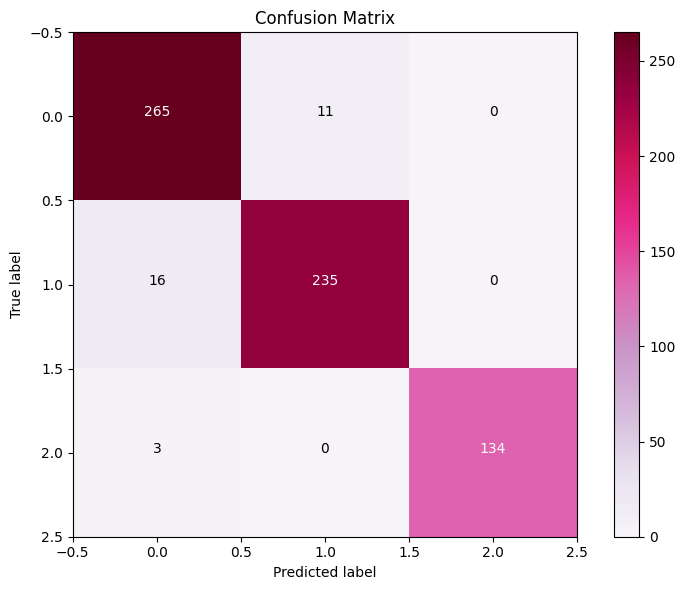

In [121]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds_Ada.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()


In [122]:
# ############# validaition_curve #####################
# from sklearn.model_selection import ValidationCurveDisplay
# ValidationCurveDisplay.from_estimator(
#    AdaBoostClassifier(**trial.params), compressed_dataset_X, label, param_name="n_estimators", param_range=range(50,500,10)
# )
# plt.show()